In [1]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())

In [2]:
tools = c('singlem', 'metaphlan', 'motus', 'kracken', 'sourmash')

In [7]:
setwd('~/m/msingle/mess/124_singlem-benchmarking/1_novel_strains/')
base_dir = 'full_run1/checkout/1_novel_strains/'

In [8]:
communities = gsub('^','marine',as.character(0:9))
communities

[1] "marine0" "marine1" "marine2" "marine3" "marine4" "marine5" "marine6"
 [8] "marine7" "marine8" "marine9"

In [9]:
d1 = data.table(expand.grid(tools, communities))
setnames(d1, c('tool', 'community'))
d1[1:3]

tool,community
<fct>,<fct>
singlem,marine0
metaphlan,marine0
motus,marine0


In [10]:
# output_singlem/opal/GCA_022615805.1_genomic.opal_report
d2 = d1[, fread(paste(base_dir,'output_',tool,sep='','/opal/',community,'.opal_report')), by=list(tool,community)]
d2[1:3]

tool,community,tool,rank,metric,sample,value
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
singlem,marine0,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [11]:
dim(d2)

[1] 9100    7

In [12]:
setnames(d2, c('tool','community','blah','rank','metric','sample','value'))
d3 = d2[blah != 'Gold standard'][,.(tool, community, rank, metric, value)]
d3[1:3]
dim(d3)

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.0006384981
singlem,marine0,phylum,Bray-Curtis distance,0.0187318686
singlem,marine0,class,Bray-Curtis distance,0.0219429962


[1] 4550    5

In [13]:
bc = d3[metric=='Bray-Curtis distance']
dim(bc)
bc[1:10]

[1] 350   5

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.0006384981
singlem,marine0,phylum,Bray-Curtis distance,0.0187318686
singlem,marine0,class,Bray-Curtis distance,0.0219429962
singlem,marine0,order,Bray-Curtis distance,0.0354324722
singlem,marine0,family,Bray-Curtis distance,0.0408631406
singlem,marine0,genus,Bray-Curtis distance,0.0514502975
singlem,marine0,species,Bray-Curtis distance,0.1120054614
metaphlan,marine0,kingdom,Bray-Curtis distance,0.0000000000
metaphlan,marine0,phylum,Bray-Curtis distance,0.1181981795


In [14]:
orders = c('kingdom','phylum','class','order','family','genus','species')
bc[, rank := factor(rank, levels=orders)]
bc[1:3]

tool,community,rank,metric,value
<fct>,<fct>,<fct>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.0006384981
singlem,marine0,phylum,Bray-Curtis distance,0.0187318686
singlem,marine0,class,Bray-Curtis distance,0.0219429962


In [15]:
average_bc = bc[, mean(value), by=list(tool)][order(V1)]
tool_order = average_bc$tool
bc[, tool := factor(tool, levels=tool_order)]

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


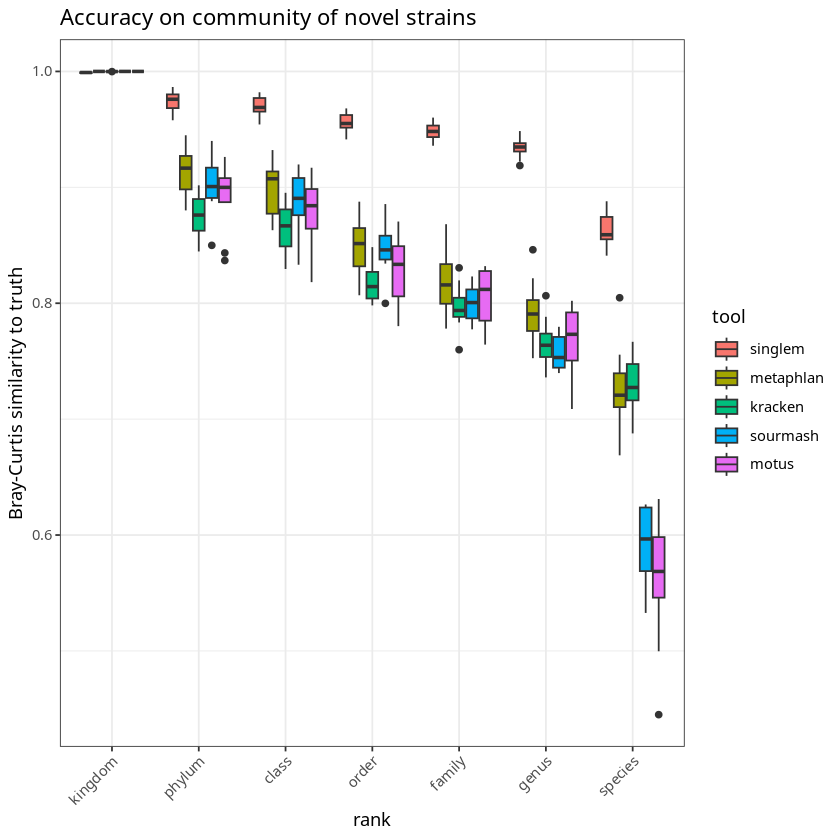

In [16]:
qplot(data=bc, rank, 1-value, geom='boxplot', fill=tool, ylab='Bray-Curtis similarity to truth', main='Accuracy on community of novel strains') + theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [17]:
# How much better is singlem than the next best tool?
means = bc[rank=='species', mean(value), by=tool][order(-V1)]
means
means[tool=='singlem', V1] - means[tool!='singlem', min(V1)]

tool,V1
<fct>,<dbl>
motus,0.4384480
sourmash,0.4092881
metaphlan,0.2722743
kracken,0.2721300
singlem,0.1375454


[1] -0.1345846

In [18]:
# write out bc
fwrite(bc, 'bray-curtis.csv', sep='\t')

# Runtime comparison

In [19]:
thread_numbers = as.character(c(1,8,32))

In [20]:
r1 = data.table(expand.grid(tools, thread_numbers, communities))
setnames(r1, c('tool', 'threads', 'community'))
r1[1:3]

tool,threads,community
<fct>,<fct>,<fct>
singlem,1,marine0
metaphlan,1,marine0
motus,1,marine0


In [21]:
r1[tool=='kracken', tool := 'kraken']
reed = function(tool,threads,community){
    # print(x)
    # f = paste(base_dir,'benchmarks/',x$tool,'/',x$community,'-',x$threads,'threads.benchmark',sep='')
    f = paste(base_dir,'benchmarks/',tool,'/',community,'-',threads,'threads.benchmark',sep='')
    # print(f)
    return(fread(f))
}
r2 = r1[, reed(tool,threads,community), by=list(tool,threads,community)]
getwd()
r2[1:3]

[1] "/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/1_novel_strains"

tool,threads,community,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
<fct>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
singlem,1,marine0,5536.106,1:32:16,1612.55,3158.88,1587.71,1591.02,64.15,1495.66,83.78,346.71
metaphlan,1,marine0,24349.448,6:45:49,17523.12,18052.73,17485.55,17499.47,7.82,9705.83,106.70,94.03
motus,1,marine0,26097.818,7:14:57,10893.61,11030.97,10886.74,10887.10,0.00,0.01,101.56,406.26


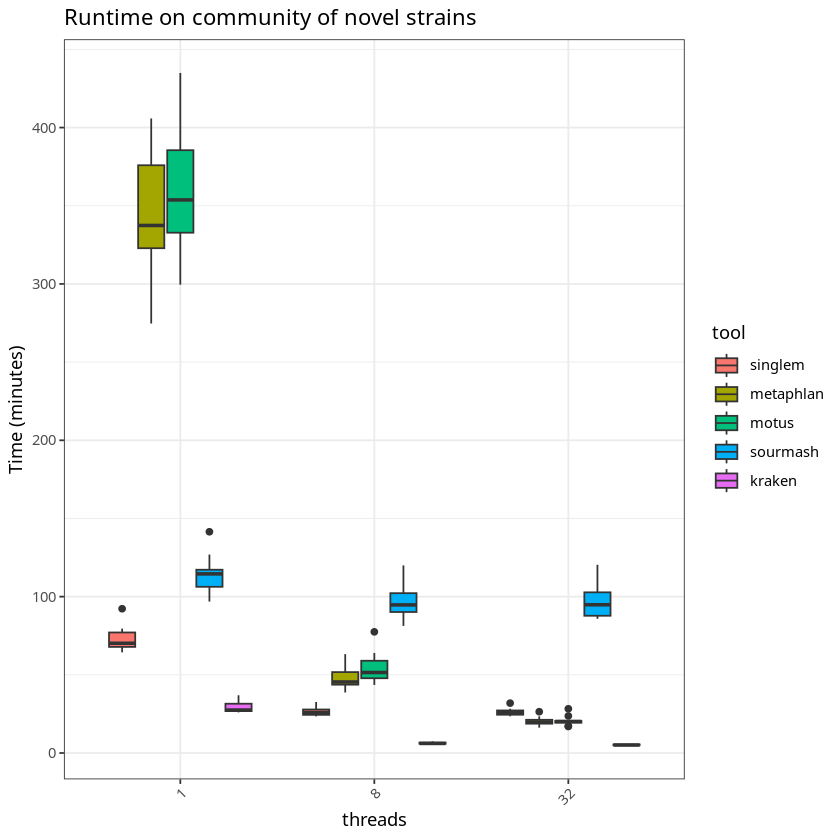

In [22]:
qplot(data=r2, threads, s/60, geom='boxplot', fill=tool, ylab='Time (minutes)', main='Runtime on community of novel strains') + theme(axis.text.x = element_text(angle = 45, hjust = 1))

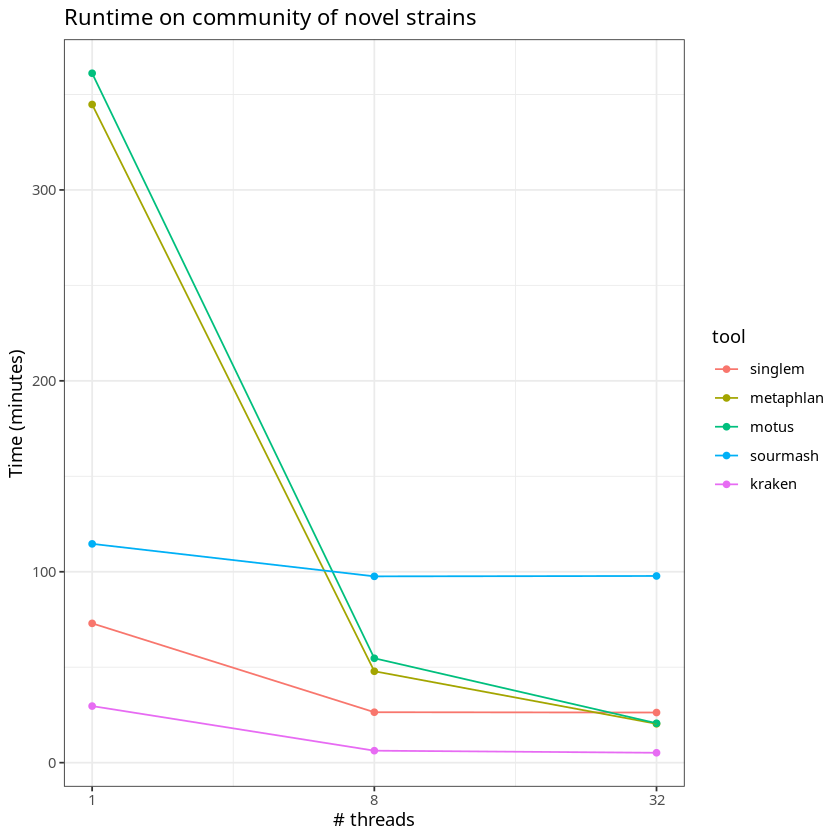

In [23]:
r3 = r2[, .(mean_s = mean(s)), by=list(tool,threads)]
# r3
qplot(data=r3, as.numeric(threads), mean_s/60, geom='point', ylab='Time (minutes)', xlab='# threads', main='Runtime on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

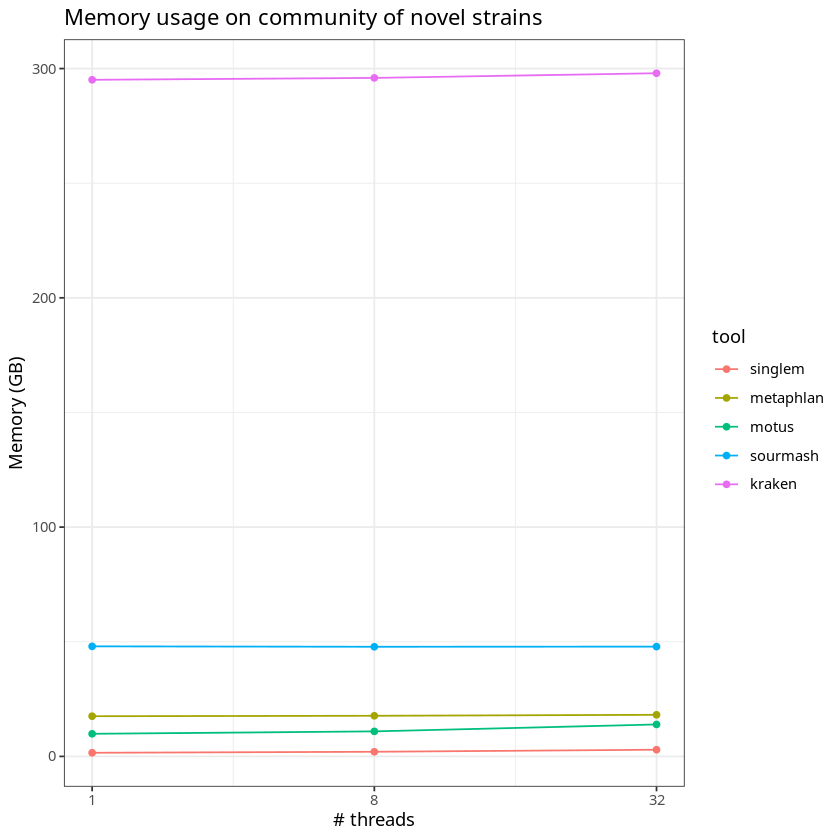

In [24]:
# RAM
r4 = r2[, .(mean_mem = mean(max_rss)), by=list(tool,threads)]
qplot(data=r4, as.numeric(threads), mean_mem/1000, geom='point', ylab='Memory (GB)', xlab='# threads', main='Memory usage on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

In [25]:
r4

tool,threads,mean_mem
<fct>,<fct>,<dbl>
singlem,1,1579.178
metaphlan,1,17525.802
motus,1,9853.306
kraken,1,295104.452
sourmash,1,47996.189
singlem,8,2014.938
metaphlan,8,17713.070
motus,8,10912.689
kraken,8,295936.022


In [26]:
# Reads per minute
read_counts = data.table(community=communities)
read_counts2 = read_counts[, fread(cmd=paste('zcat local_reads/',community,'.1.fq.gz | wc -l',sep='')), by=community]
read_counts2

community,V1
<chr>,<int>
marine0,237109868
marine1,0
marine2,0
marine3,0
marine4,0
marine5,0
marine6,0
marine7,0
marine8,0


In [27]:
rcm = merge(r2[threads==1], read_counts2, by='community')
rcm[, rpm := (V1/4)/s*60 *2] # times 2 because we only have half the reads in count
rcm[,]

community,tool,threads,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,V1,rpm
<chr>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
marine0,singlem,1,5536.106,1:32:16,1612.55,3158.88,1587.71,1591.02,64.15,1495.66,83.78,346.71,237109868,1284891.7
marine0,metaphlan,1,24349.448,6:45:49,17523.12,18052.73,17485.55,17499.47,7.82,9705.83,106.70,94.03,237109868,292133.8
marine0,motus,1,26097.818,7:14:57,10893.61,11030.97,10886.74,10887.10,0.00,0.01,101.56,406.26,237109868,272562.9
marine0,kraken,1,2215.115,0:36:55,295166.14,295200.25,295161.32,295161.85,6035.12,0.00,100.86,2234.52,237109868,3211253.6
marine0,sourmash,1,7617.124,2:06:57,49766.79,49875.14,47998.55,48876.79,61.38,163.79,99.38,5400.24,237109868,933855.8
marine1,singlem,1,4180.836,1:09:40,1577.89,3000.46,1552.90,1557.52,85.96,1097.00,80.76,253.13,0,0.0
marine1,metaphlan,1,19491.419,5:24:51,17510.25,18052.73,17439.26,17446.44,0.00,7266.23,106.21,83.60,0,0.0
marine1,motus,1,19995.391,5:33:15,9690.75,9827.16,9677.29,9678.12,0.00,0.01,101.40,315.39,0,0.0
marine1,kraken,1,1557.388,0:25:57,295092.12,295126.74,295088.73,295089.21,65286.83,0.00,101.33,1578.52,0,0.0


In [29]:
# Write rc3
fwrite(r2, 'runtime.csv', sep='\t')